In [1]:
from transformers import RobertaTokenizerFast, RobertaModel
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm


In [2]:
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.float)
        }

In [3]:
class RobertaClassifier(nn.Module):
    def __init__(self, n_classes):
        super(RobertaClassifier, self).__init__()
        self.bert = RobertaModel.from_pretrained('/root/autodl-tmp/cache')
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False
        )
        output = self.drop(pooled_output)
        return self.out(output)

In [4]:
# Load dataset
df = pd.read_csv("/root/autodl-tmp/remotefolder/cleaned_tweet_80k.csv")
texts = df['tweet'].astype(str).values
labels = df['class'].values

In [5]:
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)
print(f"train_texts length :{len(train_texts)}")
print(f"test_texts length :{len(test_texts)}")
print(f"train_labels length :{len(train_labels)}")
print(f"test_labels length :{len(test_labels)}")

train_texts length :64000
test_texts length :16000
train_labels length :64000
test_labels length :16000


In [6]:
# One-hot encode labels
ohe = OneHotEncoder(sparse_output=False)
train_labels = ohe.fit_transform(train_labels.reshape(-1, 1))
test_labels = ohe.transform(test_labels.reshape(-1, 1))

print(f"Training data: {train_texts.shape[0]}\n Validation Data: {test_texts.shape[0]}")
print(f"Training labels: {train_labels.shape}\n Validation labels: {test_labels.shape}")

Training data: 64000
 Validation Data: 16000
Training labels: (64000, 4)
 Validation labels: (16000, 4)


In [7]:
# Tokenizer
tokenizer_roberta = RobertaTokenizerFast.from_pretrained('/root/autodl-tmp/cache')
MAX_LEN = 128

In [8]:
# Create datasets and data loaders
train_dataset = CustomDataset(train_texts, train_labels, tokenizer_roberta, MAX_LEN)
test_dataset = CustomDataset(test_texts, test_labels, tokenizer_roberta, MAX_LEN)

In [9]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [10]:
# Set up model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RobertaClassifier(n_classes=4)
model = model.to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at /root/autodl-tmp/cache and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
optimizer = optim.Adam(model.parameters(), lr=1e-6)
loss_fn = nn.CrossEntropyLoss()

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)


/root/miniconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [12]:
# Training function
def train_epoch(model, data_loader, loss_fn, optimizer, device):
    model = model.train()
    total_loss = 0
    correct_predictions = 0
    total_examples = 0
    progress_bar = tqdm(data_loader, desc="Training", leave=False)

    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        loss = loss_fn(outputs, labels)
        total_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        correct_predictions += torch.sum(preds == torch.argmax(labels, dim=1)).cpu()
        total_examples += labels.size(0)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        progress_bar.set_postfix({'loss': f'{loss.item():.4f}', 'accuracy': f'{correct_predictions.double() / total_examples:.4f}'})

    avg_loss = total_loss / len(data_loader)
    avg_accuracy = correct_predictions.double() / total_examples
    return avg_loss, avg_accuracy

In [13]:
# Evaluation function
def eval_model(model, data_loader, device):
    model = model.eval()
    predictions = []
    true_labels = []
    correct_predictions = 0
    total_examples = 0
    total_loss = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            correct_predictions += torch.sum(preds == torch.argmax(labels, dim=1)).cpu()
            total_examples += labels.size(0)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(torch.argmax(labels, dim=1).cpu().detach().numpy())
    avg_loss = total_loss/len(data_loader)
    avg_accuracy = correct_predictions.double() / total_examples
    return true_labels, predictions, avg_accuracy, avg_loss


In [14]:
# Training loop
EPOCHS = 20
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    train_loss, train_accuracy = train_epoch(model, train_loader, loss_fn, optimizer, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}')
    scheduler.step(train_loss)

    _, _, val_accuracy, val_loss = eval_model(model, test_loader, device)
    val_accuracies.append(val_accuracy)
    val_losses.append(val_loss)
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')


Epoch 1/20


Training Loss: 1.3639, Training Accuracy: 0.2956
Validation Loss: 1.3308, Validation Accuracy: 0.3406
Epoch 2/20


Training Loss: 1.3262, Training Accuracy: 0.3367
Validation Loss: 1.3156, Validation Accuracy: 0.3544
Epoch 3/20


Training Loss: 1.3119, Training Accuracy: 0.3552
Validation Loss: 1.3004, Validation Accuracy: 0.3649
Epoch 4/20


Training Loss: 1.2974, Training Accuracy: 0.3693
Validation Loss: 1.2929, Validation Accuracy: 0.3711
Epoch 5/20


Training Loss: 1.2864, Training Accuracy: 0.3786
Validation Loss: 1.2893, Validation Accuracy: 0.3714
Epoch 6/20


Training Loss: 1.2773, Training Accuracy: 0.3862
Validation Loss: 1.2836, Validation Accuracy: 0.3766
Epoch 7/20


Training Loss: 1.2647, Training Accuracy: 0.3957
Validation Loss: 1.2835, Validation Accuracy: 0.3778
Epoch 8/20


Training Loss: 1.2565, Training Accuracy: 0.4030
Validation Loss: 1.2824, Validation Accuracy: 0.3766
Epoch 9/20


Training Loss: 1.2469, Training Accuracy: 0.4101
Validation Loss: 1.2778, Validation Accuracy: 0.3784
Epoch 10/20


Training Loss: 1.2351, Training Accuracy: 0.4185
Validation Loss: 1.2832, Validation Accuracy: 0.3802
Epoch 11/20


Training Loss: 1.2239, Training Accuracy: 0.4269
Validation Loss: 1.2854, Validation Accuracy: 0.3813
Epoch 12/20


Training Loss: 1.2129, Training Accuracy: 0.4340
Validation Loss: 1.2870, Validation Accuracy: 0.3813
Epoch 13/20


Training Loss: 1.2014, Training Accuracy: 0.4428
Validation Loss: 1.2912, Validation Accuracy: 0.3786
Epoch 14/20


Training Loss: 1.1918, Training Accuracy: 0.4508
Validation Loss: 1.2921, Validation Accuracy: 0.3822
Epoch 15/20


Training Loss: 1.1806, Training Accuracy: 0.4568
Validation Loss: 1.2938, Validation Accuracy: 0.3842
Epoch 16/20


Training Loss: 1.1682, Training Accuracy: 0.4648
Validation Loss: 1.2973, Validation Accuracy: 0.3840
Epoch 17/20


Training Loss: 1.1568, Training Accuracy: 0.4753
Validation Loss: 1.3108, Validation Accuracy: 0.3845
Epoch 18/20


Training Loss: 1.1447, Training Accuracy: 0.4787
Validation Loss: 1.3102, Validation Accuracy: 0.3830
Epoch 19/20


Training Loss: 1.1340, Training Accuracy: 0.4891
Validation Loss: 1.3238, Validation Accuracy: 0.3845
Epoch 20/20


Training Loss: 1.1207, Training Accuracy: 0.4939
Validation Loss: 1.3310, Validation Accuracy: 0.3824


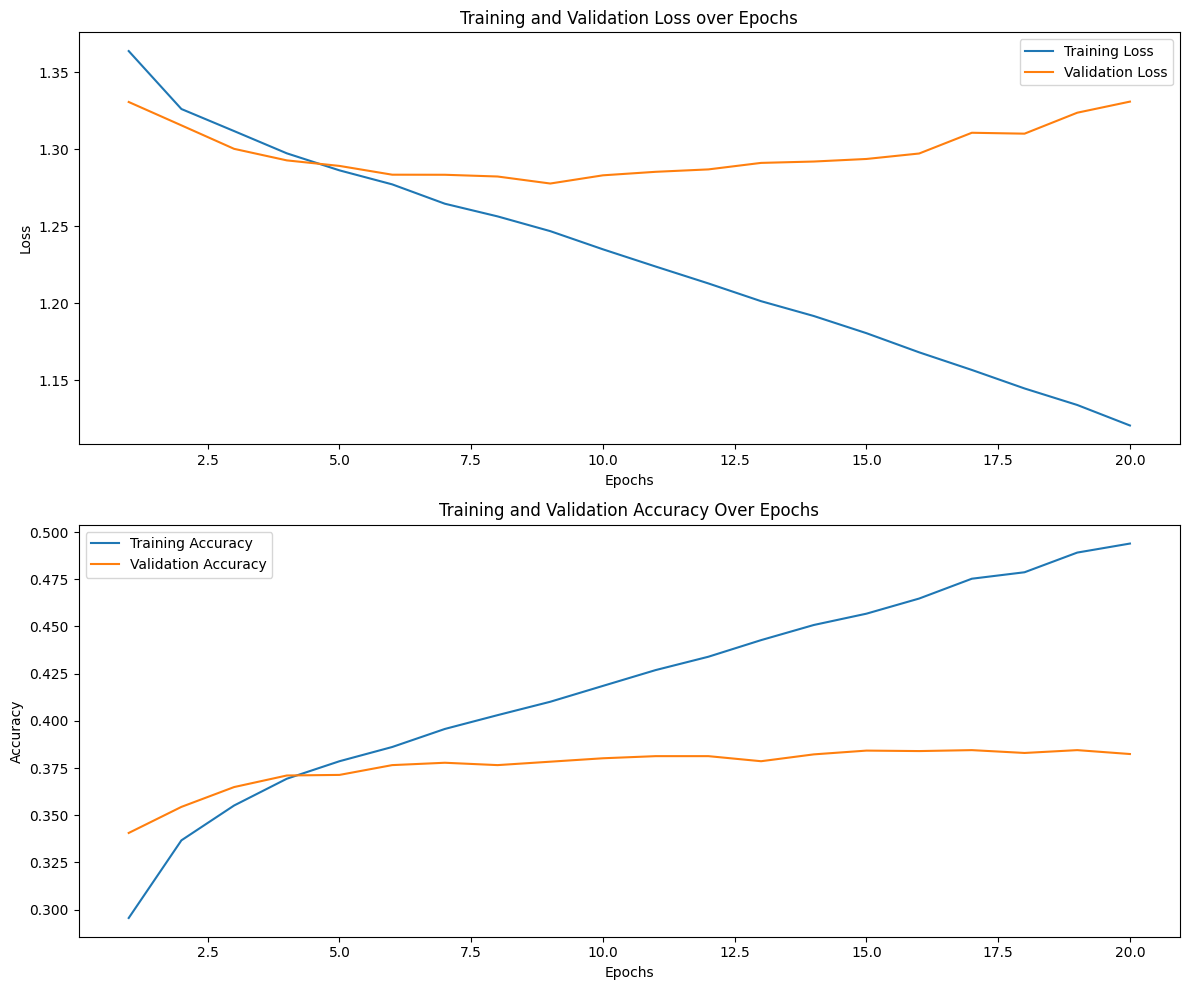

In [18]:
# Plotting training loss and accuracy
plt.figure(figsize=(12, 10))

# Loss plot
plt.subplot(2, 1, 1)
plt.plot(range(1,EPOCHS +1), train_losses, label='Training Loss')
plt.plot(range(1, EPOCHS+1), val_losses, label ='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()

# Accuracy plot
plt.subplot(2, 1, 2)
plt.plot(range(1, EPOCHS + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, EPOCHS + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

Test Accuracy: 0.3824


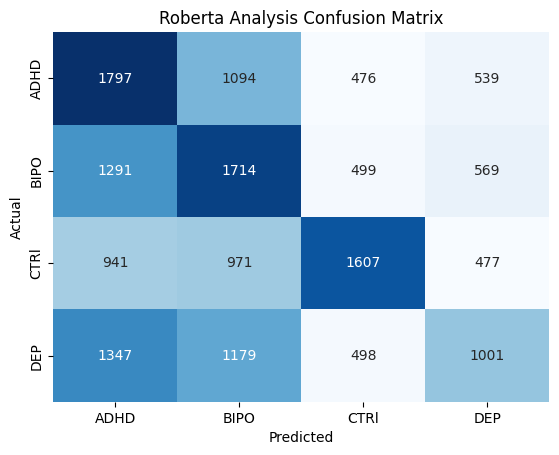

              precision    recall  f1-score   support

        ADHD       0.33      0.46      0.39      3906
     BIPOLAR       0.35      0.42      0.38      4073
     CONTROL       0.52      0.40      0.45      3996
  DEPRESSION       0.39      0.25      0.30      4025

    accuracy                           0.38     16000
   macro avg       0.40      0.38      0.38     16000
weighted avg       0.40      0.38      0.38     16000



In [16]:
# Evaluation
y_true, y_pred, test_accuracy, _ = eval_model(model, test_loader, device)
print(f'Test Accuracy: {test_accuracy:.4f}')
conf_matrix = confusion_matrix(y_true, y_pred)
labels=["ADHD", "BIPO", "CTRl", "DEP"]
fig, ax = plt.subplots()
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt='g', cbar=False)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Roberta Analysis Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred, target_names=["ADHD", "BIPOLAR", "CONTROL", "DEPRESSION"]))